## **REINFORCE ALGORITHM WITHOUT BASELINE FOR CARTPOLE ENVIRONMENT**

In [ ]:
import gym
import random
import numpy as np
import tensorflow as tf
from collections import deque
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

In [ ]:
class Policy(nn.Module):

  def __init__(self,state_size=4,hidden_size=128,num_actions=2):
    super(Policy,self).__init__()

    self.fc1 = nn.Linear(state_size,hidden_size)
    self.fc2 = nn.Linear(hidden_size,num_actions)

  def forward(self,x):

    fcHid = F.relu(self.fc1(x))
    out = self.fc2(fcHid)
    p = F.softmax(out,dim=1)

    return p

  def chooseAct(self,x):
    x = torch.from_numpy(x).float().unsqueeze(0)
    prob = self.forward(x)
    model = Categorical(prob)
    act = model.sample() # randomly sample an action

    return act.item(),model.log_prob(act)


In [ ]:
def reinforce(policy, optimizer, num_episodes = 500, max_timesteps = 500, gamma = 0.99):
  scores = []
  scores_deque = deque(maxlen = 100)
  for episode in range(num_episodes):
    state = env.reset()
    rewards = []
    log_probs_all = []
    # simulate an episode until end
    for t in range(max_timesteps):
      action,log_probs = policy.chooseAct(state)
      state,reward,done,_ = env.step(action)
      rewards.append(reward)
      log_probs_all.append(log_probs)
      if done:
        break
    scores.append(sum(rewards))
    scores_deque.append(scores)

    # calculate discounted returns for the episode using rewards obtained
    discounted_returns = []
    sumR = 0
    for r in reversed(rewards):
      sumR = sumR + gamma * r #r + gamma*(sumR)
      discounted_returns.insert(0,sumR)

    # Calculate the loss
    policy_loss = []
    i = 0
    for log_prob in log_probs_all:
        R = discounted_returns[i]
        policy_loss.append(-log_prob * R)
        i += 1
    policy_loss = torch.cat(policy_loss).sum()

    optimizer.zero_grad()
    policy_loss.backward()
    optimizer.step()
    print(f"Episode {episode}: Reward = {sum(rewards)}")
  return scores


In [ ]:
n_episodes = 1000
num_runs = 5
scores_all_runs = np.zeros((num_runs,n_episodes))
for r in range(num_runs):
  env = gym.make('CartPole-v1')
  policy = Policy()
  optimizer = optim.Adam(policy.parameters(), lr=1e-3)
  scores = reinforce(policy, optimizer, num_episodes = n_episodes)
  scores_all_runs[r,:] = scores

In [ ]:
# saving the scores file across 5 runs
import pandas as pd
file_path = '/content/REINFORCE_wout_baseline_cartpole.xlsx'

pd.DataFrame(scores_all_runs).to_excel(file_path,index=False)


# **REINFORCE ALGORITHM WITHOUT BASELINE FOR CARTPOLE ENVIRONMENT**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import gym
import numpy as np
from collections import deque

In [22]:
class PolicyNetwork(nn.Module):
  def __init__(self, state_size = 4, hidden_size = 128, num_actions = 2):
    super(PolicyNetwork, self).__init__()
    self.input_layer = nn.Linear(state_size, hidden_size)
    self.output_layer = nn.Linear(hidden_size, num_actions)
    # self.output_layer = nn.Linear(hidden2_size, num_actions)

  def forward(self, x):
    x = self.input_layer(x)
    x = F.relu(x)
    actions = self.output_layer(x)
    action_probs = F.softmax(actions, dim=1)

    return action_probs

  def select_action(self, x):
    x = torch.from_numpy(x).float().unsqueeze(0)
    action_probs = self.forward(x)
    m = Categorical(action_probs)
    action = m.sample()
    return action.item(), m.log_prob(action)

In [23]:
#Using a neural network to learn state value
class StateValueNetwork(nn.Module):
  def __init__(self, state_size = 4, hidden_size = 128, num_vals = 1):
    super(StateValueNetwork, self).__init__()

    self.input_layer = nn.Linear(state_size, hidden_size)
    self.output_layer = nn.Linear(hidden_size, num_vals)

  def forward(self, x):
    x = self.input_layer(x)
    x = F.relu(x)
    state_value = self.output_layer(x)

    return state_value

In [24]:
def calculate_baseline(rewards):
  G = []
  total_r = 0
  for r in reversed(rewards):
      total_r = r + total_r * gamma
      G.insert(0, total_r)
  #whitening rewards
  G = torch.tensor(G)
  G = (G - G.mean())/G.std()

  return G

In [26]:
def train_policyNet(deltas, log_probs, optimizer):
  policy_loss = []
  for d, lp in zip(deltas, log_probs):
      policy_loss.append(-d * lp)

  #Backpropagation
  optimizer.zero_grad()
  sum(policy_loss).backward()
  optimizer.step()


In [27]:
def train_valueNet(G, state_vals, optimizer):
    #calculate MSE loss
    val_loss = F.mse_loss(state_vals, G)
    #Backpropagate
    optimizer.zero_grad()
    val_loss.backward()
    optimizer.step()

In [ ]:
gamma = 0.99
num_epsiodes = 1000
max_timesteps = 500
num_runs = 5
scores_all_runs = np.zeros((num_runs,num_epsiodes))
env = gym.make('CartPole-v1')
for r in range(num_runs):
  policy_network = PolicyNetwork(env.observation_space.shape[0], env.action_space.n)
  stateval_network = StateValueNetwork(env.observation_space.shape[0])
  policy_optimizer = optim.Adam(policy_network.parameters(), lr=1e-2)
  stateval_optimizer = optim.Adam(stateval_network.parameters(), lr=1e-2)
  scores = []
  recent_scores = deque(maxlen=100)
  for episode in range(num_epsiodes):
      state = env.reset()
      trajectory = []
      score = 0

      for step in range(max_timesteps):
          action, lp = policy_network.select_action(state)
          new_state, reward, done, _ = env.step(action)
          score += reward
          trajectory.append([state, action, reward, lp])
          if done:
              break
          state = new_state
      scores.append(score)
      recent_scores.append(score)

      states = [step[0] for step in trajectory]
      actions = [step[1] for step in trajectory]
      rewards = [step[2] for step in trajectory]
      lps = [step[3] for step in trajectory]
      state_vals = []
      for state in states:
          state = torch.from_numpy(state).float().unsqueeze(0)
          state_vals.append(stateval_network(state))

      state_vals = torch.stack(state_vals).squeeze()

      # G = calculate_td_estimate(rewards,state_vals,gamma)
      G = calculate_baseline(rewards)
      train_valueNet(G, state_vals, stateval_optimizer)

      deltas = [gt - val for gt, val in zip(G, state_vals)]
      deltas = torch.tensor(deltas)

      train_policyNet(deltas, lps, policy_optimizer)

      print(f"Episode: {episode}, Score: {score}")
  scores_all_runs[r,:] = scores
  # env.close()

In [40]:
# saving the scores file across 5 runs
import pandas as pd
file_path = '/content/REINFORCE_w_baseline_cartpole.xlsx'

pd.DataFrame(scores_all_runs).to_excel(file_path,index=False)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'Compare REINFORCE with vs without baseline for CartPole Environment')

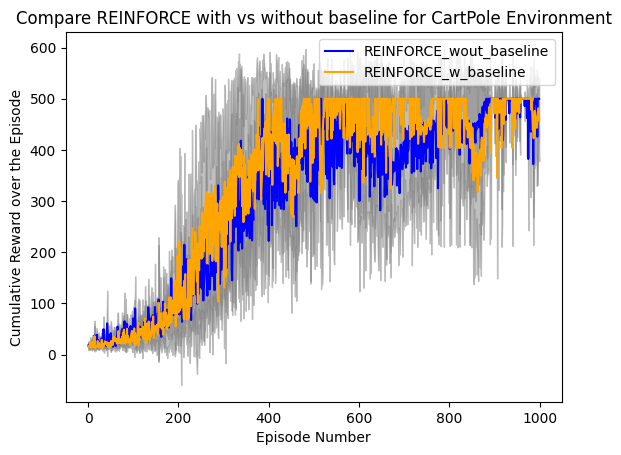

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

num_episodes = 1000

wout_baseline = np.array(pd.read_excel('REINFORCE_wout_baseline_cartpole.xlsx'))
w_baseline = np.array(pd.read_excel('REINFORCE_w_baseline_cartpole.xlsx'))

mean_scores_wout = np.mean(wout_baseline[:,:1000],axis=0)
std_scores_wout = np.std(wout_baseline[:,:1000],axis=0)

mean_scores_w = np.mean(w_baseline,axis=0)
std_scores_w = np.std(w_baseline,axis=0)

plt.figure()
plt.plot(np.arange(num_episodes),mean_scores_wout,color='blue',label='REINFORCE_wout_baseline')
plt.fill_between(np.arange(num_episodes), mean_scores_wout - std_scores_wout, mean_scores_wout + std_scores_wout, color='gray', alpha=0.5)
plt.plot(np.arange(num_episodes),mean_scores_w,color='orange',label='REINFORCE_w_baseline')
plt.fill_between(np.arange(num_episodes), mean_scores_w - std_scores_w, mean_scores_w + std_scores_w, color='gray', alpha=0.5)
plt.legend()
plt.xlabel('Episode Number')
plt.ylabel('Cumulative Reward over the Episode')
plt.title('Compare REINFORCE with vs without baseline for CartPole Environment')

In [53]:
# For finding the means every 10 episodes
smoothened_means = np.zeros((100,2))
smoothened_stds = np.zeros((100,2))

for_mean_wout = deque(maxlen=10)
for_std_wout = deque(maxlen=10)

for_mean_w = deque(maxlen=10)
for_std_w = deque(maxlen=10)
c = 0
for i in range(1000):
  for_mean_wout.append(wout_baseline[:,i])
  for_mean_w.append(w_baseline[:,i])
  if i % 10 == 0:
    smoothened_means[c,0] = np.mean(for_mean_wout)
    smoothened_means[c,1] = np.mean(for_mean_w)
    smoothened_stds[c,0] = np.std(for_mean_wout)
    smoothened_stds[c,1] = np.std(for_mean_w)
    c += 1

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'Compare REINFORCE with vs without baseline for CartPole Environment')

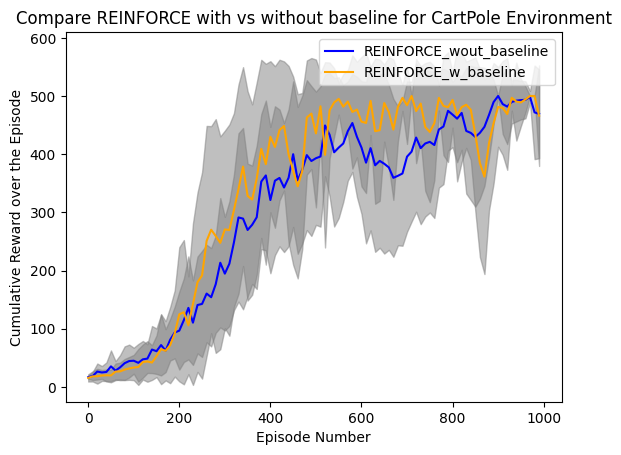

In [54]:
plt.figure()
plt.plot(np.arange(100)*10,smoothened_means[:,0],color='blue',label='REINFORCE_wout_baseline')
plt.fill_between(np.arange(100)*10, smoothened_means[:,0] - smoothened_stds[:,0], smoothened_means[:,0] + smoothened_stds[:,0], color='gray', alpha=0.5)
plt.plot(np.arange(100)*10,smoothened_means[:,1],color='orange',label='REINFORCE_w_baseline')
plt.fill_between(np.arange(100)*10, smoothened_means[:,1] - smoothened_stds[:,1], smoothened_means[:,1] + smoothened_stds[:,1], color='gray', alpha=0.5)
plt.legend()
plt.xlabel('Episode Number')
plt.ylabel('Cumulative Reward over the Episode')
plt.title('Compare REINFORCE with vs without baseline for CartPole Environment')